In [ ]:
import os 
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import seaborn as sns
from zipfile import ZipFile
from tqdm import tqdm
import warnings 
warnings.filterwarnings("ignore")
import random
import cv2
from sklearn.model_selection import KFold
from imgaug import augmenters as ia
import glob, sys, json, urllib
from sklearn.utils import shuffle
import multiprocess as mp

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###Description 
   To train triplet network network I am using street2shop dataset I am downloading the dataset by following the instructions provided <a href = "http://www.tamaraberg.com/street2shop/"> here </a> <br>
   There are basically three folder which contain all the information that is needed to create anchor images, positive images and negative images dataset. Folders provided in the metadata are train, test and retrieval. In the train/test folder we have separate json files corresponding to each class, example 'train_pair_footwear.json', in these json file we have given 'photo id' which is id of street photo, 'bounding box' info such as width, height, top, left this helpful in cropping exact region of product of interest cause the same street image can have multiple products in it, at a time we will be focusing on one product only, The field 'product id' represents the id of product which is present in cropped region of street image. Here in train/test folder we have given product id and street photo id, we also need to know corresponding shop photo id of the because we need pair of images to be sent to the triplet network, so to get shop photo id product id to photo id mapping is given in retrieval folder for each class json file is provided in the retrieval folder structure of the json file is [product id, photo id]. <br> 

   There is photo.txt file which contains photo id (shop photo id or street photo id) and corresponding url to get the image with that id. <br> 
   
   Using the information provided in the train, test and retrieval folder we will create meta_df pandas dataframe with columns as type, category, street_photo_id, shop_photo_id, width, top, height, left this dataframe will help us in creating final dataset.<br>

In [ ]:
!cp -r '/content/drive/MyDrive/fashion_data/triplet/meta/meta/json' file_json
!cp '/content/drive/MyDrive/fashion_data/triplet/photos/photos.txt' photos.txt

In [ ]:
meta_df = pd.DataFrame({'type' : [], 'category' : [], 'street_photo_id' : [], 'product_id' : [], 'width' : [], 'top' : [], 'height' : [], 'left' : []})

for filename in os.listdir('file_json') :
    if filename.split('_')[0] != 'retrieval' and filename != '.DS_Store' :
        json_temp = json.load(open('file_json/' + filename, 'r'))
        typee = str(filename.split('_')[0])
        category = str(filename.split('_')[2])
        category = category[0 : category.find('.')]
        for item in json_temp :
            temp_df = pd.DataFrame([[typee, category, item['photo'], item['product'], item['bbox']['width'], \
                                                   item['bbox']['top'], item['bbox']['height'], item['bbox']['left']]], \
                                                   columns = meta_df.columns)  
            meta_df = pd.concat([meta_df, temp_df], ignore_index = True)


In [ ]:
meta_df.head()

,type,category,street_photo_id,product_id,width,top,height,left
0,train,pants,2470.0,804.0,1037.0,3091.0,2132.0,1267.0
1,train,pants,16441.0,1118.0,1001.0,2062.0,783.0,573.0
2,train,pants,12418.0,2431.0,191.0,897.0,976.0,253.0
3,train,pants,3682.0,3893.0,863.0,891.0,2262.0,915.0
4,train,pants,13786.0,1318.0,697.0,1859.0,930.0,378.0


In [ ]:
retrieve_df = pd.DataFrame({'category' : [],  'shop_photo_id' : [],'product_id' : []})

for filename in tqdm(os.listdir('file_json')) :
    if filename.split('_')[0] == 'retrieval' :
        category = str(filename.split('_')[1])
        category = category[0 : category.find('.')]
        json_temp = json.load(open('file_json/' + filename, 'r'))
        print(filename, len(json_temp))
        for item in json_temp :
            temp_df = pd.DataFrame([[category, item['photo'], item['product']]], columns = retrieve_df.columns)
            retrieve_df = pd.concat([retrieve_df, temp_df], ignore_index = True)

  0%|          | 0/34 [00:00<?, ?it/s]

retrieval_eyewear.json 1595


  9%|▉         | 3/34 [00:02<00:24,  1.25it/s]

retrieval_tops.json 68478


 24%|██▎       | 8/34 [02:04<03:24,  7.88s/it]

retrieval_skirts.json 18295


 26%|██▋       | 9/34 [02:46<07:29, 18.00s/it]

retrieval_pants.json 7641


 41%|████      | 14/34 [03:04<04:34, 13.72s/it]

retrieval_bags.json 16319


 53%|█████▎    | 18/34 [03:49<03:27, 12.98s/it]

retrieval_dresses.json 169941


 56%|█████▌    | 19/34 [15:30<54:50, 219.38s/it]

retrieval_belts.json 1252


 65%|██████▍   | 22/34 [15:37<30:50, 154.24s/it]

retrieval_footwear.json 75853


 68%|██████▊   | 23/34 [22:44<43:15, 235.93s/it]

retrieval_hats.json 2551


 79%|███████▉  | 27/34 [22:59<19:24, 166.30s/it]

retrieval_outerwear.json 34744


 85%|████████▌ | 29/34 [26:40<12:28, 149.63s/it]

retrieval_leggings.json 8228


100%|██████████| 34/34 [27:34<00:00, 48.67s/it] 


In [ ]:
retrieve_df.head()

,category,shop_photo_id,product_id
0,eyewear,232932.0,1.0
1,eyewear,272515.0,2.0
2,eyewear,185483.0,3.0
3,eyewear,222162.0,4.0
4,eyewear,184282.0,5.0


### Analysis and Preprocessing

1) There are only 20357 street images and 404483 shop images and 11 different classes. The category wise distribution in street and shop images can also be seen.

Number of Street Images =  20357
Number of Shop Images 404483

AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


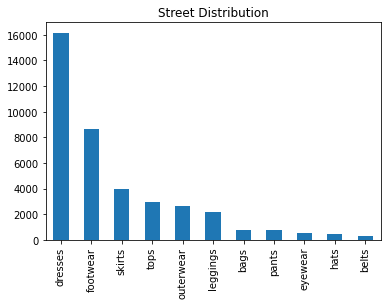

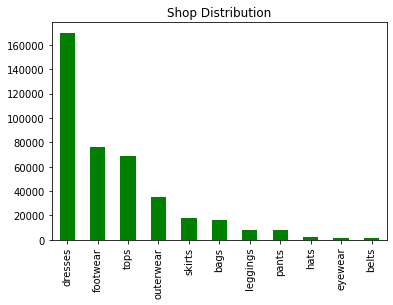

In [ ]:
print('Number of Street Images = ', len(set(meta_df['street_photo_id'])))
print('Number of Shop Images', len(set(retrieve_df['shop_photo_id'])))
print()
plt.figure()
print(meta_df['category'].value_counts().plot(kind = 'bar', title = 'Street Distribution'))
plt.figure()
print(retrieve_df['category'].value_counts().plot(kind = 'bar', title = 'Shop Distribution', color = 'g'))

2) Three things we need to keep in mind, first one is the street model can be seen wearing number of products, second one is the same product can be worn by number of street models and third one is for the product present in the street image we can have more than one matching shop images.<br>

  A) In first image we can see that the model has worn different items such as jacket, bag, shoes, dress etc. <br>

  B) In the second image we can see that shop photo has repeated entries it is because the same item (In this case dress) was worn by different models and hence repeated entries. <br>


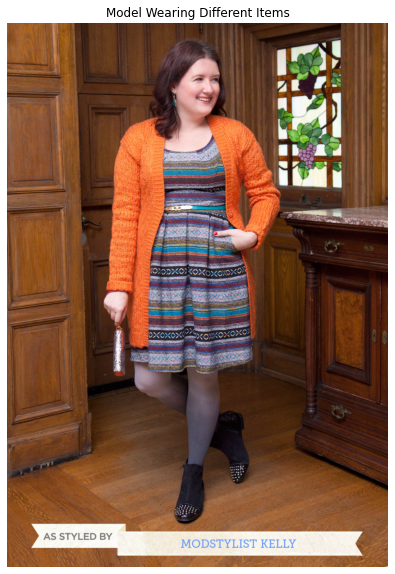

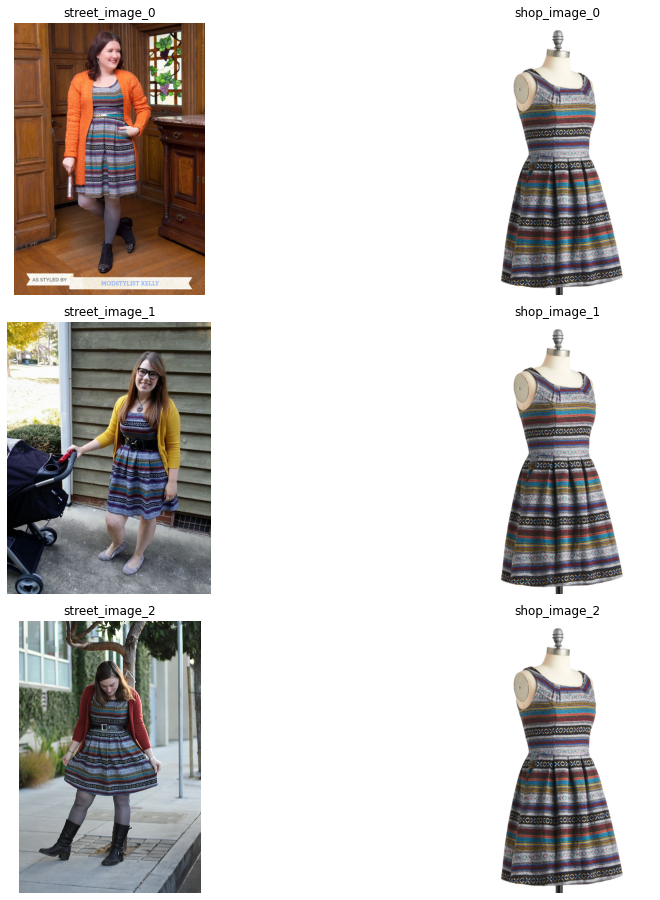

In [ ]:
## Case I
urllib.request.urlretrieve('http://media1.modcloth.com/community_outfit_image/000/000/010/220/img_full_c3173c2d7ed0.jpg', 'street_multiple.jpg')
fig = plt.figure(figsize = (16, 10))
im = cv2.imread('street_multiple.jpg')
im = cv2.cvtColor(im, code = cv2.COLOR_BGR2RGB)
plt.title('Model Wearing Different Items')
plt.imshow(im)
plt.axis('off')

shop_url_list = ['http://productshots0.modcloth.net/productshots/0118/8638/952f36d65034aede9242a9a5e4629bd5.jpg?1346793758\n', 'http://productshots0.modcloth.net/productshots/0118/8638/952f36d65034aede9242a9a5e4629bd5.jpg?1346793758\n', 'http://productshots0.modcloth.net/productshots/0118/8638/952f36d65034aede9242a9a5e4629bd5.jpg?1346793758\n']
street_url_list = ['http://media1.modcloth.com/community_outfit_image/000/000/010/220/img_full_c3173c2d7ed0.jpg\n', 'http://media1.modcloth.com/community_outfit_image/000/000/100/182/img_full_bf59b32534e5.jpg\n', 'http://media1.modcloth.com/community_outfit_image/000/000/007/841/img_full_f5dc9d17ce31.jpg\n']

## Case II
fig, ax = plt.subplots(3, 2, figsize = (16, 16))
for i, (street_url, shop_url) in enumerate(zip(street_url_list, shop_url_list)) :
    urllib.request.urlretrieve(street_url, 'street_multiple.jpg')
    im = cv2.imread('street_multiple.jpg')
    im = cv2.cvtColor(im, code = cv2.COLOR_BGR2RGB)
    ax[i][0].imshow(im)
    ax[i][0].set_title('street_image_{}'.format(i))
    ax[i][0].axis('off')

    urllib.request.urlretrieve(shop_url, 'shop_multiple.jpg')
    im = cv2.imread('shop_multiple.jpg')
    im = cv2.cvtColor(im, code = cv2.COLOR_BGR2RGB)
    ax[i][1].imshow(im)
    ax[i][1].set_title('shop_image_{}'.format(i))
    ax[i][1].axis('off')

plt.subplots_adjust(wspace=0.01, hspace=0.1)
    

C)To verify the third thing we will join meta_df and retrieve df so that we can have street_photo_id and corresponding shop_photo_id in a single row, we will join both dataframes on ['category', 'product_id']. From the dataframe we can see that, the given street_photo with some product_id has number of matching shop images, for example there are multiple entries for street photo id 14537 and product id 286.

AxesSubplot(0.125,0.125;0.775x0.755)


,type,category,street_photo_id,product_id,width,top,height,left,shop_photo_id
0,train,pants,2470.0,804.0,1037.0,3091.0,2132.0,1267.0,20960.0
1,train,pants,2470.0,804.0,1037.0,3091.0,2132.0,1267.0,20961.0
2,train,pants,2470.0,804.0,1037.0,3091.0,2132.0,1267.0,20962.0
3,train,pants,2470.0,804.0,1037.0,3091.0,2132.0,1267.0,20963.0
4,train,pants,2470.0,804.0,1037.0,3091.0,2132.0,1267.0,97508.0


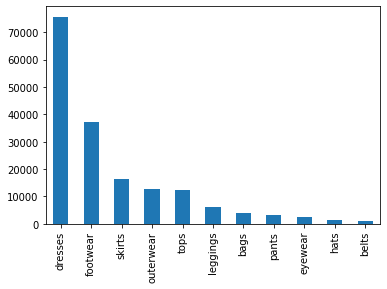

In [ ]:
meta_df_new = pd.merge(meta_df, retrieve_df, on = ['category', 'product_id'], how = 'inner')
print(meta_df_new['category'].value_counts().plot(kind = 'bar'))
meta_df_new.head()

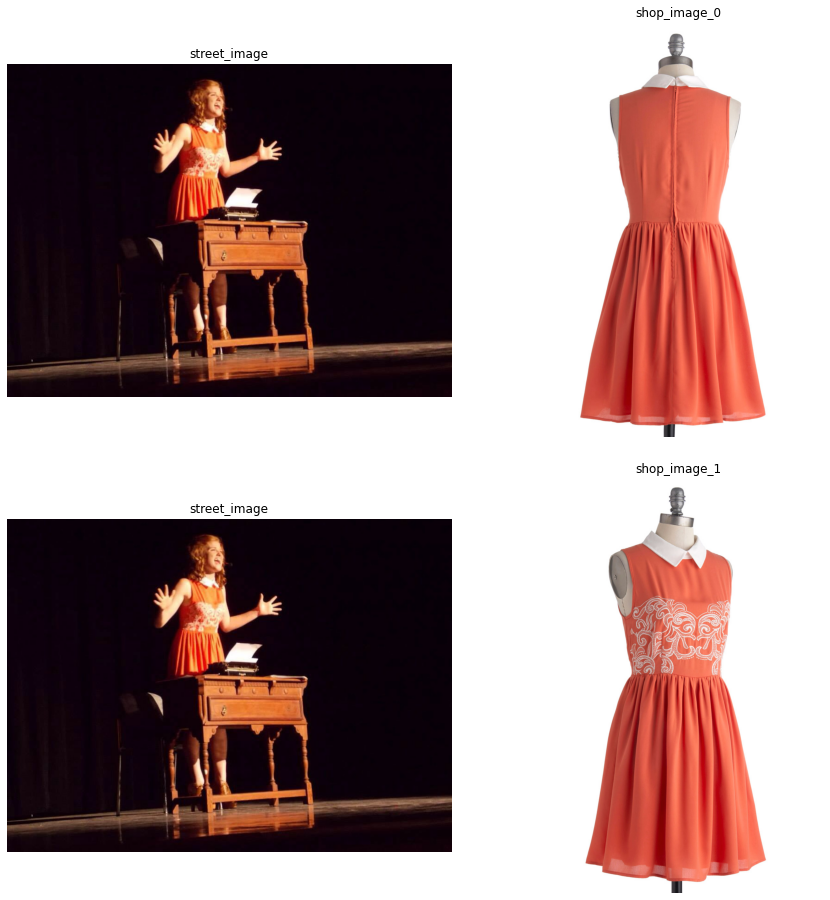

In [ ]:
street_url = 'http://media1.modcloth.com/community_outfit_image/000/000/185/212/img_full_3668308b292c.jpg'
shop_url_list = ['http://productshots3.modcloth.net/productshots/0129/6655/1ffcd9f5d7ec8e2ef96472d868a0881a.jpg?1370466784\n', 'http://productshots0.modcloth.net/productshots/0129/6653/c23bddd4d3eafbde2093f0c72865a230.jpg?1370466779\n']

fig, ax = plt.subplots(2, 2, figsize = (16, 16))
for i, shop_url in enumerate(shop_url_list) :
    urllib.request.urlretrieve(street_url, 'street_multiple.jpg')
    im = cv2.imread('street_multiple.jpg')
    im = cv2.cvtColor(im, code = cv2.COLOR_BGR2RGB)
    ax[i][0].imshow(im)
    ax[i][0].set_title('street_image')
    ax[i][0].axis('off')

    urllib.request.urlretrieve(shop_url, 'shop_multiple.jpg')
    im = cv2.imread('shop_multiple.jpg')
    im = cv2.cvtColor(im, code = cv2.COLOR_BGR2RGB)
    ax[i][1].imshow(im)
    ax[i][1].set_title('shop_image_{}'.format(i))
    ax[i][1].axis('off')

plt.subplots_adjust(wspace=0.01, hspace=0.1)

3) street_photo_id and shop_photo_id must be two distinct sets so, if we take set intersection between these two sets we must get empty set. Lets verifye this using set operations.

In [ ]:
print('Intesection set cardinality = ', len(set(meta_df_new['street_photo_id']).intersection(set(meta_df_new['shop_photo_id']))))

Intesection set cardinality =  0


4) We have around 424840 total images that is too much we need to be selective in order to get rid of disk issues. We will create photos.csv file in which the fields are photo id and photo url the file is created for ease of access. This csv file will be later used to get urls of street and shop images.

In [ ]:
photos_url = open('photos.txt', 'r')
counter = 0
for url in photos_url :
    counter += 1
print('Total images = ',counter)
photos_url.seek(0, 0)
photos_df = pd.DataFrame({'photo_id' : [],  'photo_url' : []})
corrupt_counter = 0
for url in tqdm(photos_url):
    urlX = str(url.split(',')[1])
    photo_id = int(url.split(',')[0].lstrip('0'))
    temp_df = pd.DataFrame([[photo_id, urlX]], columns = photos_df.columns)
    photos_df = pd.concat([photos_df, temp_df], ignore_index = True)

photos_df.to_csv('/content/drive/MyDrive/fashion_data/triplet/photos_df.csv', index = False)
photos_df.head()

5) As there are too many images we will only work with 30000 images in order to get 30000 I first thought of taking any 30000 random images but in this process we may face a condition where in we will have street image but correspoding paired shop image is not present so to avoid this I have created final_df dataframe. This dataframe will have shop_photo_id , shop_photo_url, street_photo_id and street_photo_url and some other field. To download the images we will loop through each row and parallely download both street and shop image. <br>

To get the required df we will first join meta_df_new with photo_df on photo_id and street_photo_id it will gives url of street_photo_id lets call this column as 'street_photo_url' <br> 

To get 'shop_photo_url' we will join meta_df_new with photos_df on photo_id and shop_photo_id

In [ ]:
meta_df_new[['street_photo_id', 'product_id', 'width', 'top','height', 'left', 'shop_photo_id']] = meta_df_new[['street_photo_id', 'product_id', 'width', 'top',
       'height', 'left', 'shop_photo_id']].astype(int)

photos_df['photo_id'] = photos_df['photo_id'].astype(int)
photos_df.columns = ['street_photo_id', 'street_photo_url']
meta_df_new = meta_df_new.merge(photos_df, on = ['street_photo_id'],how = 'inner')

photos_df.columns = ['shop_photo_id', 'shop_photo_url']
meta_df_new = meta_df_new.merge(photos_df, on = ['shop_photo_id'],how = 'inner')
meta_df_new.to_csv('/content/drive/MyDrive/fashion_data/triplet/copy1.csv', index = False)   ## Save the copy

In [ ]:
temp_df = pd.read_csv('/content/drive/MyDrive/fashion_data/triplet/copy1.csv')
temp_df.head()

,type,category,street_photo_id,product_id,width,top,height,left,shop_photo_id,street_photo_url,shop_photo_url
0,test,hats,14537,286,611,60,457,377,63021,http://media1.modcloth.com/community_outfit_im...,http://productshots2.modcloth.net/productshots...
1,test,hats,18232,286,1141,535,916,829,63021,http://media1.modcloth.com/community_outfit_im...,http://productshots2.modcloth.net/productshots...
2,test,hats,3396,286,543,185,500,635,63021,http://media1.modcloth.com/community_outfit_im...,http://productshots2.modcloth.net/productshots...
3,test,hats,3396,286,579,200,486,1971,63021,http://media1.modcloth.com/community_outfit_im...,http://productshots2.modcloth.net/productshots...
4,test,hats,3396,286,500,1692,465,2121,63021,http://media1.modcloth.com/community_outfit_im...,http://productshots2.modcloth.net/productshots...


6) Removing corrupted images : <br>

   As the dataset is old the most of the image urls are not working. We will remove the entries in meta_df_new assosiated with corrupted images. I also shuffled the meta_df_new so that we dont get all images of same class. The process I followed was to loop till 50000 iterations hoping to get 30000 images in just 50000 iterations. I have used multiprocess library to processs the url requests parallely I first did not use it, it was taking 9 to run 30000 iterations but after the using the Pool I managed to loop through 50000 iterations in an half hour.I made parallel 32 processes each process will take one row of dataframe and check if shop photo url or street photo url is corrupted or not if not corrupted then download both images and set is_selected field to 1 meaning this row is selected. If any one of the image is corrupted set is_selected to 0 and delete the image that you just downloaded that is if the error shows up in shop_url then you must have already downloaded the street_url you have to delete this in order to save the space and if error shows up in street_url then there is nothing to be deleted as nothing has been downloaded yet. <br>



In [ ]:
%%time
!rm -rf '/content/drive/MyDrive/fashion_data/triplet/images_triplet/'
!mkdir '/content/drive/MyDrive/fashion_data/triplet/images_triplet/'
meta_df_new = pd.read_csv('/content/drive/MyDrive/fashion_data/triplet/copy1.csv')
image_path = '/content/drive/MyDrive/fashion_data/triplet/images_triplet/'

CPU times: user 487 ms, sys: 95.2 ms, total: 583 ms
Wall time: 876 ms


In [ ]:
%%time
meta_df_new = shuffle(meta_df_new)

def optimized(args) :
    i, row = args
    street_url = row['street_photo_url']
    shop_url = row['shop_photo_url']
    try : 
        urllib.request.urlretrieve(street_url, image_path + str(row['street_photo_id']) + '.jpg') 
        urllib.request.urlretrieve(shop_url, image_path + str(row['shop_photo_id']) + '.jpg')
        row['is_selected'] = 1
    except :
        try :
            os.remove(image_path + str(row['street_photo_id']) + '.jpg') ## delete image if fails this was causing the issue but we cant remove it, it has to be present
        except :
            pass
        row['is_selected'] = 0
    return row

df_new = meta_df_new[0:50000]
pool = mp.Pool(processes = 32)
series_list = pool.map(optimized, [(i, row) for i, row in df_new.iterrows()])

CPU times: user 1min 18s, sys: 17.7 s, total: 1min 36s
Wall time: 29min 22s


7) Removing Incosistencies : <br>

At this point we have is_selected field with us telling whether the row is selected or not. But, even after careful processing I had some rows where is_selected is 1 but correspoding street image is not present in the triplet_image folder. After lots of debugging I managed to find out the issue, Ths issue was the street image can have multiple products in it so there are other rows present in the df with same street url but with different shop image. Suppose there is a processX and at time 't' it is processing rowX hits the street and shop urls and get the images downloaded it also make is_selected as 1. Lets say there is other process "processY" at time t + 10 processing rowY which has the same street url as that of street url of rowX but different shop url and unfortunately its shop_url is down so "processY" wont be able to download the shop image and when it fails according to our logic code will delete the its street image but the street image was also the street image of rowX. So code will end up deleting rowX's street image, this will create problem in processing the images further we have to deal with this. The solution to this problem is simple we will again loop through the df for each row we will check if the street image path is exists or not if it does not exist we will set that row's is_selected as 0.

In [ ]:
### setting corrupted rows' is_selected as 0 .

stored_df = pd.concat(series_list, axis = 1).T
count = 0
image_path = '/content/drive/MyDrive/fashion_data/triplet/images_triplet/'

for ind, row in stored_df.iterrows() :
    if row['is_selected'] :
        path = image_path + str(row['street_photo_id']) + '.jpg' 
        if not os.path.exists(path) :
            stored_df.at[ind, 'is_selected'] = 0
            count +=1

print('Total street photos = ', len(set(stored_df[stored_df['is_selected'] == 1]['street_photo_id'])))
print('Total shop photos = ', len(set(stored_df[stored_df['is_selected'] == 1]['shop_photo_id'])))

stored_df = stored_df[stored_df['is_selected'] == 1].reset_index()
stored_df.to_csv('/content/drive/MyDrive/fashion_data/triplet/final_triplet.csv', index = False)  ## Saving file 


Total street photos =  12628
Total shop photos =  19631


8)Distribution of categories <br>
The distribution of variour categories in the final data is same as the distribution we had earlier. 

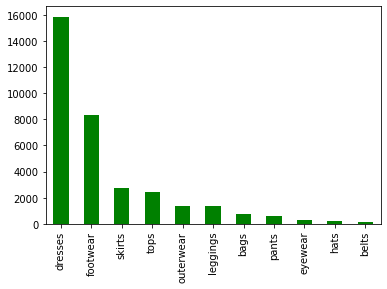

In [ ]:
stored_df['category'].value_counts().plot(kind = 'bar', color = 'g')  ## Distribution of various classes in final df

10) Visualization : <br>

Let's visualize some of the pairs of street and shop images that we have in our dataset. It also helps in checking whether all the processing was correctely done or not.

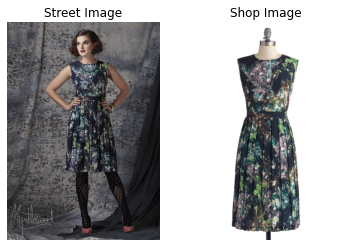

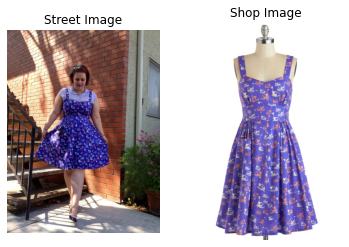

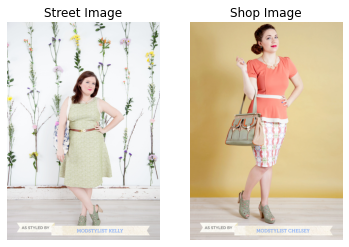

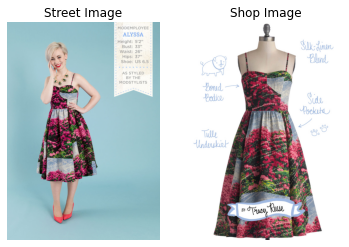

In [ ]:
for i in range(4) :    
    stored_df = shuffle(stored_df)
    row = stored_df[stored_df['is_selected'] == 1].iloc[100]
    street_path = str(row['street_photo_id']) + '.jpg'
    shop_path = str(row['shop_photo_id']) + '.jpg'
    street_path = image_path + street_path
    shop_path = image_path + shop_path
    img_street = plt.imread(street_path)
    img_shop = plt.imread(shop_path)
    fig, ax = plt.subplots(1, 2)
    ax[0].set_title('Street Image')
    ax[0].imshow(img_street)
    ax[0].axis('off')
    ax[1].set_title('Shop Image')
    ax[1].imshow(img_shop)
    ax[1].axis('off')